# Imports

In [1]:
import sys, os, time, copy, random, math
import numpy as np
import pandas as pd
import pickle
from glob import glob
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

%reload_ext autoreload
%autoreload 2

# Load the data

In [4]:
path = '</path/to/AMIE/data/>'
df_angles = pd.read_hdf(os.path.join(path, 'angles.hdf'))
df_index = pd.read_hdf(os.path.join(path, 'overview.hdf'))

In [5]:
print('People:', np.unique(df_index.person.values))
print('Exercises:', np.unique(df_index.exercise.values))
print('Execution_type:', np.unique(df_index.execution_type.values))

People: ['evgeniya' 'gust' 'jessa' 'pedro' 'sergey' 'stella' 'tim' 'tom' 'toon'
 'vincent']
Exercises: ['lunge' 'sidelunge' 'squat']
Execution_type: [1 2 3 4]


# Functions

In [7]:
def filter_id_labels(index_frame, normal={}, anomaly={}, limit_anoms=0, sort=False, shuffle=False):
    
    rep_id = np.array([])
    
    # select the anomaly rep_ids
    for person, exs in anomaly.items():
        ix_p = np.where(index_frame.person.values == person)[0]
        p_frame = index_frame.iloc[ix_p, :].copy()
        for ex, etype in exs.items():
            ix_e = np.where(p_frame.exercise.values == ex)[0]
            ix_etype = np.where(p_frame.execution_type == etype)[0]
            ix = np.intersect1d(ix_e, ix_etype)
            anom_rep = p_frame.iloc[ix, -1].values
            rep_id = np.concatenate((rep_id, anom_rep))
    
    if limit_anoms > 0:
        rep_id = rep_id[:limit_anoms]
    n_anom = len(rep_id)
    
    # select the normal rep_ids
    for person, exs in normal.items():
        ix_p = np.where(index_frame.person.values == person)[0]
        p_frame = index_frame.iloc[ix_p, :].copy()
        for ex, etype in exs.items():
            ix_e = np.where(p_frame.exercise.values == ex)[0]
            ix_etype = np.where(p_frame.execution_type == etype)[0]
            ix = np.intersect1d(ix_e, ix_etype)
            norm_rep = p_frame.iloc[ix, -1].values
            rep_id = np.concatenate((rep_id, norm_rep))
    
    # labels
    labels = np.ones(len(rep_id), dtype=float) * -1
    labels[:n_anom] = 1.0
    
    # sort
    if shuffle:
        ix_shuffle = np.arange(0, len(rep_id), 1)
        random.shuffle(ix_shuffle)
        rep_id = rep_id[ix_shuffle]
        labels = labels[ix_shuffle]
    elif sort:
        ix_sort = np.argsort(rep_id)
        rep_id = rep_id[ix_sort]
        labels = labels[ix_sort]
    else:
        pass
    
    return rep_id, labels

In [8]:
def apply_filter_and_PCA(angle_frame, rep_ids, labels, ndims=3):
    """ Select the exercises from the frame + apply PCA """
    
    norm_ix = np.where(labels == -1.0)[0]
    norm_ids = rep_ids[norm_ix]
    
    y = np.array([])
    ix_select = np.array([])
    angle_ids = angle_frame.rep_id.values
    for i, rid in enumerate(rep_ids):
        ix_match = np.where(angle_ids == rid)[0]
        ix_select = np.concatenate((ix_select, ix_match))
        if rid in norm_ids:
            y = np.concatenate((y, np.ones(len(ix_match), dtype=float) * -1))
        else:
            y = np.concatenate((y, np.ones(len(ix_match), dtype=float)))
    
    # select the data
    data_frame = angle_frame.iloc[ix_select, :-1].copy()
    data = data_frame.values
    
    # apply PCA
    pca = PCA(n_components=ndims)
    X = pca.fit_transform(data)
    
    # final frame
    new_frame = pd.DataFrame(X)
    new_frame.columns = ['pc'+str(i+1) for i in range(ndims)]
    new_frame['label'] = y
    
    return new_frame, data_frame

In [18]:
def plot_angles(frame, angle_frame, names, plot_angles=True):
    plot_data = angle_frame.values
    N, na = plot_data.shape
    labels = frame.label.values
    
    if plot_angles:
    
        print('\nANGLES:')

        # construct the plots
        fig, axes = plt.subplots(na, 1, figsize=(50, 1 * na))
        plt.rc('text', usetex=True)
        plt.rc('font', family='CM')

        # populate the plots
        for i in range(na):
            # data + indicate anomalies
            to_plot = (plot_data[:, i] - min(plot_data[:, i])) / (max(plot_data[:, i]) - min(plot_data[:, i]))
            axes[i].plot(to_plot)
            axes[i].fill_between(np.arange(0, N, 1), 0, 1, where=labels > 0.5, facecolor='red', alpha=0.30)

            # clean up
            axes[i].set_xlim([0, N])
            if i + 1 < na:
                axes[i].set_xticklabels([])
            axes[i].set_yticklabels([])
            #axes[i].legend()

        plt.show()
    
    plot_data = frame.iloc[:, :-1].values
    N2, npc = plot_data.shape
    
    print('\nPCA reduced:')
    
    
    # construct the plots
    fig, axes = plt.subplots(npc, 1, figsize=(50, 1 * npc))
    if npc == 1:
        axes = [axes]
    plt.rc('text', usetex=True)
    plt.rc('font', family='CM')
    
    # populate the plots
    for i in range(npc):
        # data + indicate anomalies
        to_plot = (plot_data[:, i] - min(plot_data[:, i])) / (max(plot_data[:, i]) - min(plot_data[:, i]))
        axes[i].plot(to_plot)
        axes[i].fill_between(np.arange(0, N2, 1), 0, 1, where=labels > 0.5, facecolor='red', alpha=0.30)
        
        # clean up
        axes[i].set_xlim([0, N2])
        if i + 1 < na:
            axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        #axes[i].legend()
    
    plt.show()

In [10]:
def plot_temp_results(frame, rres):
    
    plot_data = frame.iloc[:, :-1].values
    N2, npc = plot_data.shape
    labels = frame.label.values

    # construct the plots
    fig, axes = plt.subplots(npc, 1, figsize=(50, 1 * npc))
    plt.rc('text', usetex=True)
    plt.rc('font', family='CM')
    
    # populate the plots
    for i in range(npc):
        # data + indicate anomalies
        to_plot = (plot_data[:, i] - min(plot_data[:, i])) / (max(plot_data[:, i]) - min(plot_data[:, i]))
        axes[i].plot(to_plot)
        axes[i].fill_between(np.arange(0, N2, 1), 0, 1, where=labels > 0.5, facecolor='red', alpha=0.30)
        
        # clean up
        axes[i].set_xlim([0, N2])
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
    
    plt.show()
    
    print('AUC = ' + str(roc_auc_score(y_true=rres['true'], y_score=rres['prob'])))
    
    plt.figure(figsize=(50, 3))
    plt.plot((rres['prob'] - min(rres['prob'])) / (max(rres['prob']) - min(rres['prob'])), color='red')
    plt.plot(rres['true'], color='red')
    plt.xlim([0, len(rres['prob'])])
    plt.show()

In [11]:
def store_frame(frame, path_suffix, settings):
    path = os.path.join('</path/to/store/location/>', path_suffix)
    if not os.path.exists(path):
        os.makedirs(path)
    frame.to_csv(os.path.join(path, 'train_data.csv'), sep=',')
    with open(os.path.join(path, 'data_settings.pickle'), 'wb') as handle:
        pickle.dump(settings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
def fast_divide_into_windows_no_timestamps(X, y, w_size, w_increment, window_scores=False):
    """ Divide the data into windows """
    n = len(X)
    n_windows = math.floor((n - w_size) / w_increment + 1)

    labels = np.zeros(n_windows, dtype=float)
    segments = np.zeros((n_windows, int(w_size)), dtype=float)
    for i in range(n_windows):
        # data
        w = int(i*w_increment)
        segment = X[w:w+w_size]
        segments[i, :] = segment

        # labels
        lbl_segment = y[int(i*w_increment):int((i*w_increment)+w_size)]
        cntr = Counter(lbl_segment)
        if cntr[-1.0] == 0 and cntr[1.0] == 0:  # no labels
            labels[i] = 0.0
        elif cntr[1.0] > 0:  # anomaly
            labels[i] = 1.0
        else:  # normal
            labels[i] = -1.0

    return segments, labels

# Prepare the datasets

## DNAME: simple_test_1

In [31]:
normal = {'evgeniya': {'squat': [1]}}
anomaly = {'evgeniya': {'squat': [2]}}
ids, labels = filter_id_labels(df_index, normal, anomaly, 5, sort=True, shuffle=True)
print('IDS:', ids)
print('Labels:', labels)

IDS: [ 20.  22.   9.  15.   7.  28.  14.   0.  25.  19.  29.  13.  27.  21.   5.
  23.  16.   4.  10.  26.   8.   1.   6.  32.   3.  30.  18.  12.  11.  31.
  17.  24.   2.]
Labels: [-1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.]


In [32]:
df, full_df = apply_filter_and_PCA(df_angles, ids, labels, ndims=4)

In [47]:
settings = {'dname': 'simple_test_1', 'scaling': False, 'data_type': 'multivariate', 'wsize': 100, 'wincrement': 50, 'discretize': True, 'alphabet_size': 30,
            'PCA': 'yes', 'ndims': 3, 'norm_anom': 'evgeniya_squat_1__evgeniya_squat_2', 'anom_limit': 5}
store_frame(df, 'simple_test_3pca', settings)


ANGLES:


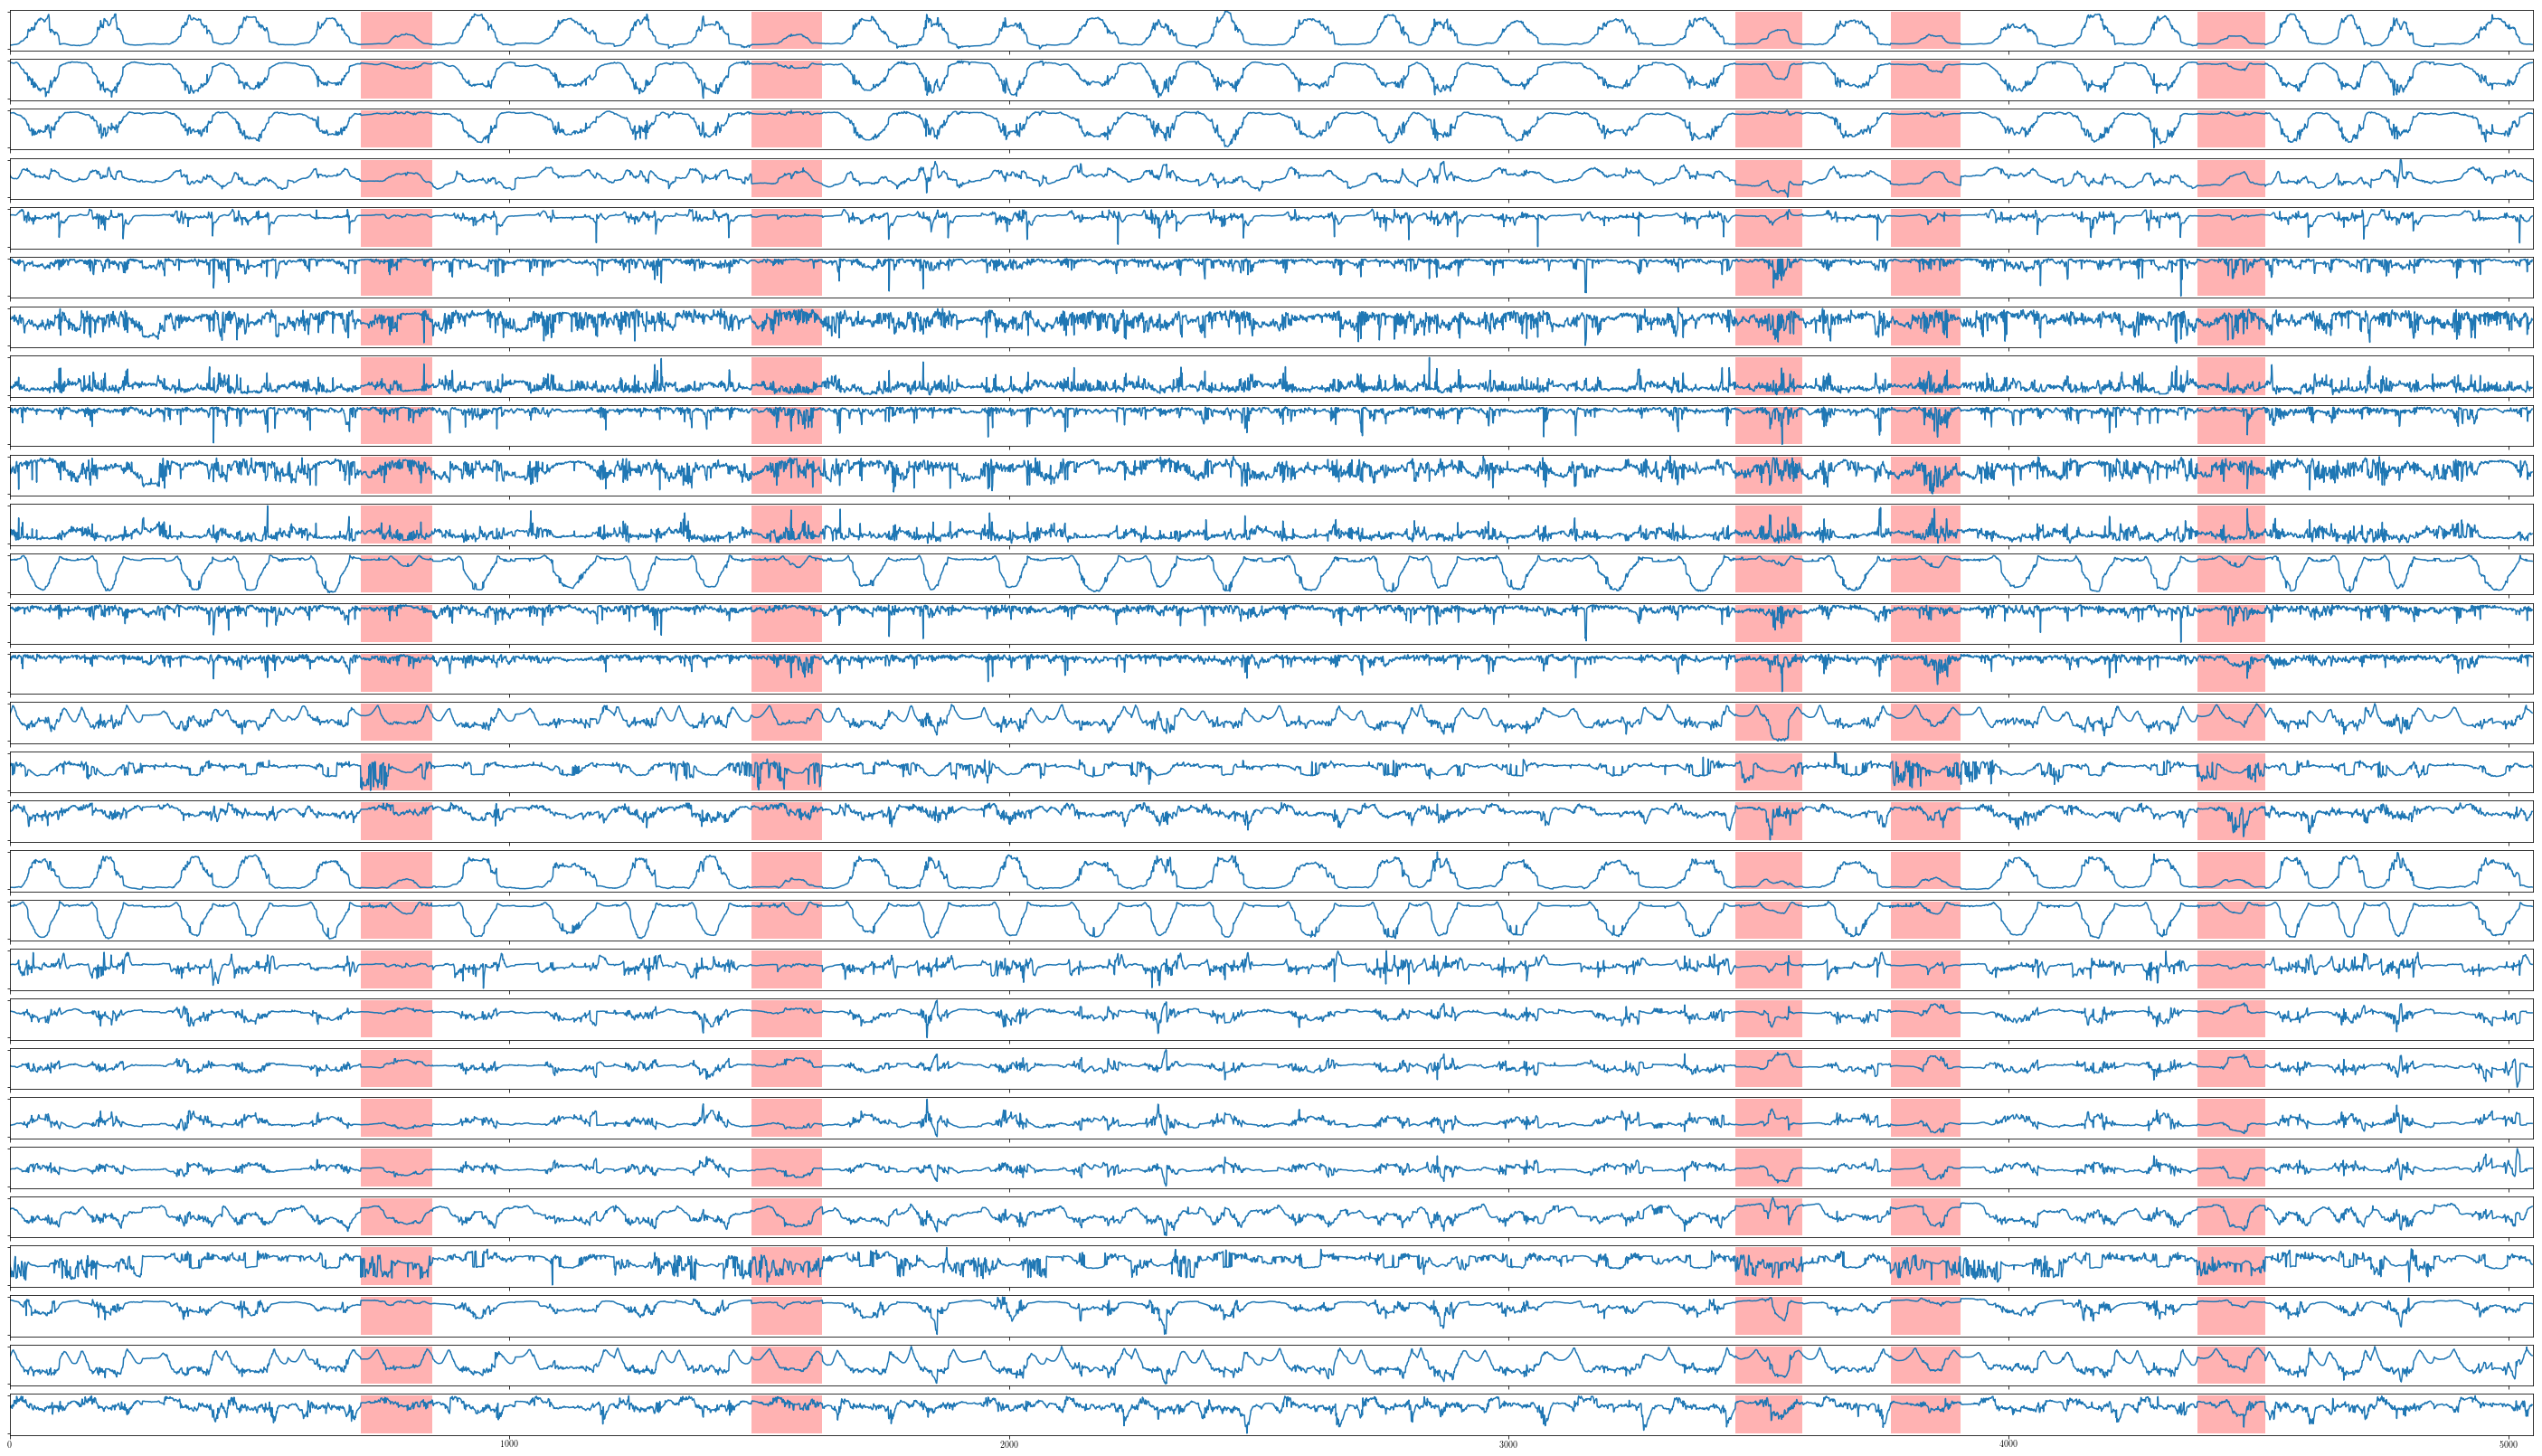


PCA reduced:


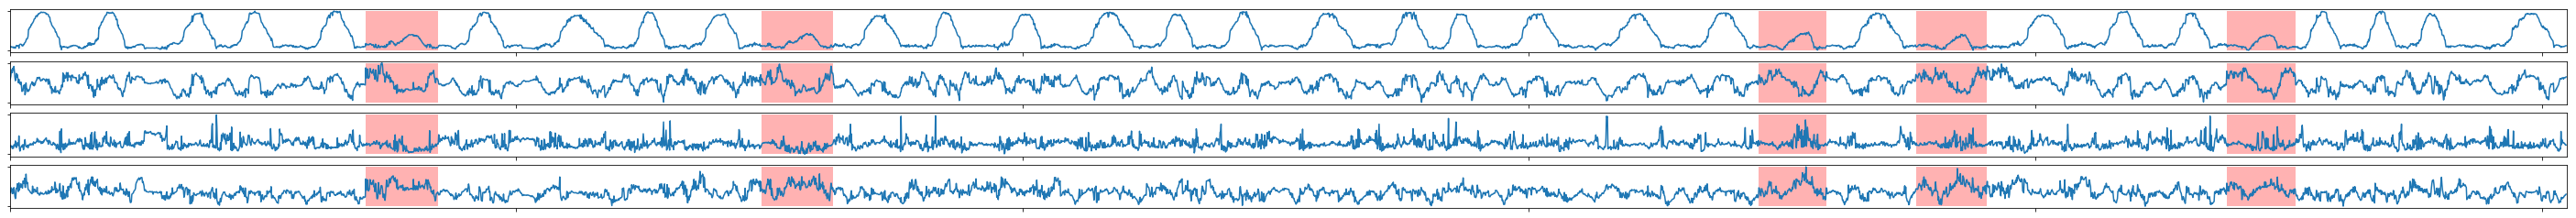

In [34]:
plot_angles(df, full_df, full_df.columns)

# Time series discretization

In [39]:
timeseries = df.pc1.values
T2, T3 = _discretize_time_series(timeseries, 30, 10)

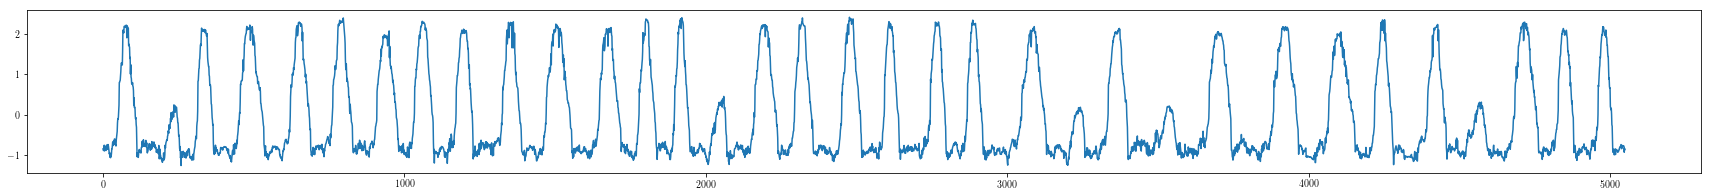

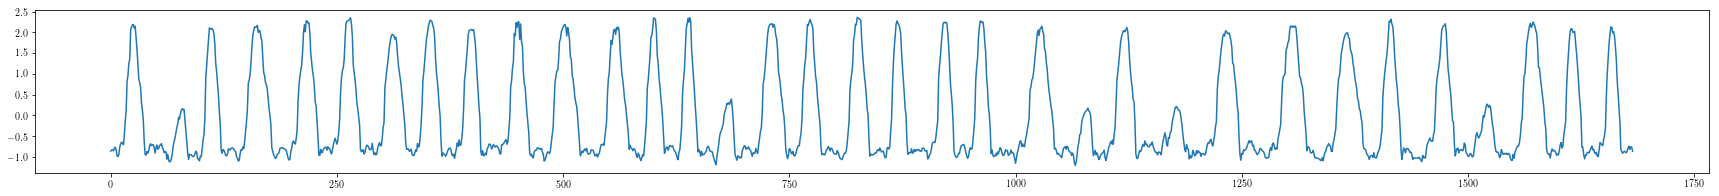

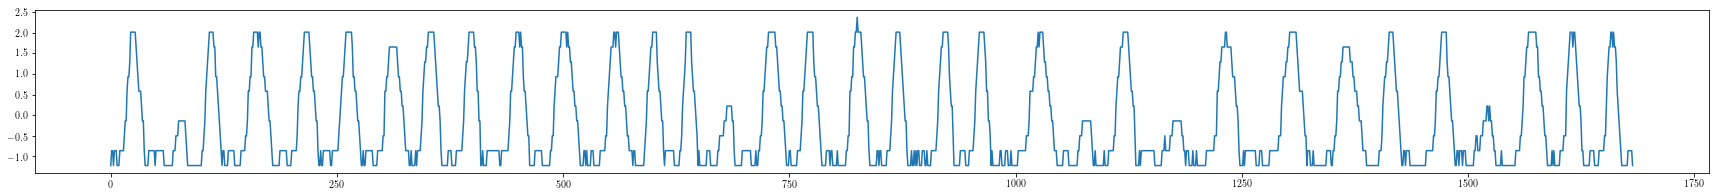

In [170]:
plt.figure(figsize=(30, 3))
plt.plot(timeseries)

plt.figure(figsize=(30, 3))
plt.plot(T2)

plt.figure(figsize=(30, 3))
plt.plot(T3)

# Generate benchmark datasets

## Benchmark 1 (3 PCA): squats vs sidelunge


PCA reduced:


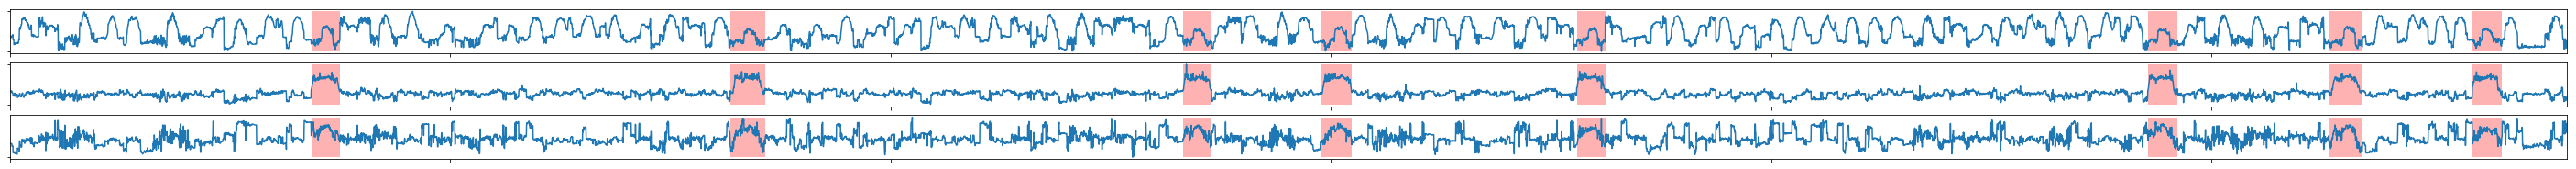


PCA reduced:


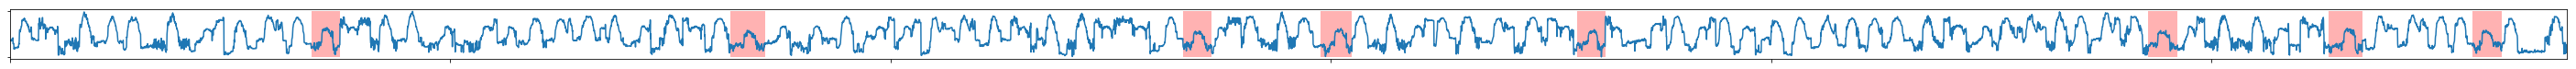

In [22]:
random.seed(30)

DNAME = 'squats_vs_sidelunges'
normal = {'toon': {'squat': [1]}, 'gust': {'squat': [1]}, 'tim': {'squat': [1]}}
anomaly = {'gust': {'sidelunge': [1]}}
ids, labels = filter_id_labels(df_index, normal, anomaly, 8, sort=True, shuffle=True)

df, full_df = apply_filter_and_PCA(df_angles.copy(), ids, labels, ndims=3)
plot_angles(df, full_df, full_df.columns, plot_angles=False)

df, full_df = apply_filter_and_PCA(df_angles.copy(), ids, labels, ndims=1)
plot_angles(df, full_df, full_df.columns, plot_angles=False)

In [35]:
# (w_size, w_increment, bin_size)
wc = [(10, 1, 10)]

for i, c in enumerate(wc):
    settings = {'dname': DNAME, 'scaling': False, 'data_type': 'multivariate', 'discretize': True, 'alphabet_size': 30, 'PCA': 'yes', 'ndims': 3, 'anom_limit': 8,
               'wsize': c[0], 'wincrement': c[1], 'bin_size': c[2]}
    store_frame(df, 'benchmark1_3pca_variation_'+str(i), settings)

## Benchmark 2 (3 PCA): sidelunge vs lunges


PCA reduced:


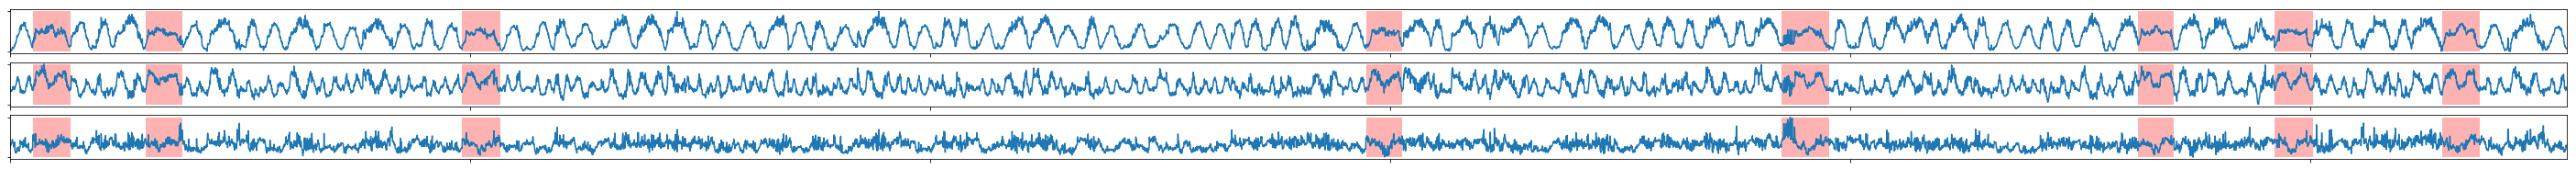

In [39]:
DNAME = 'sidelunges_vs_lunges'
normal = {'evgeniya': {'sidelunge': [1]}, 'stella': {'sidelunge': [1]}, 'jessa': {'sidelunge': [1]}}
anomaly = {'jessa': {'lunge': [1]}}
ids, labels = filter_id_labels(df_index, normal, anomaly, 8, sort=True, shuffle=True)
df, full_df = apply_filter_and_PCA(df_angles, ids, labels, ndims=3)

plot_angles(df, full_df, full_df.columns, plot_angles=False)

In [40]:
# (w_size, w_increment, bin_size)
wc = [(10, 1, 10)]

for i, c in enumerate(wc):
    settings = {'dname': DNAME, 'scaling': False, 'data_type': 'multivariate', 'discretize': True, 'alphabet_size': 30, 'PCA': 'yes', 'ndims': 3, 'anom_limit': 8,
               'wsize': c[0], 'wincrement': c[1], 'bin_size': c[2]}
    store_frame(df, 'benchmark2_3pca_variation_'+str(i), settings)

## Benchmark 3 (3 PCA): lunges vs squats


PCA reduced:


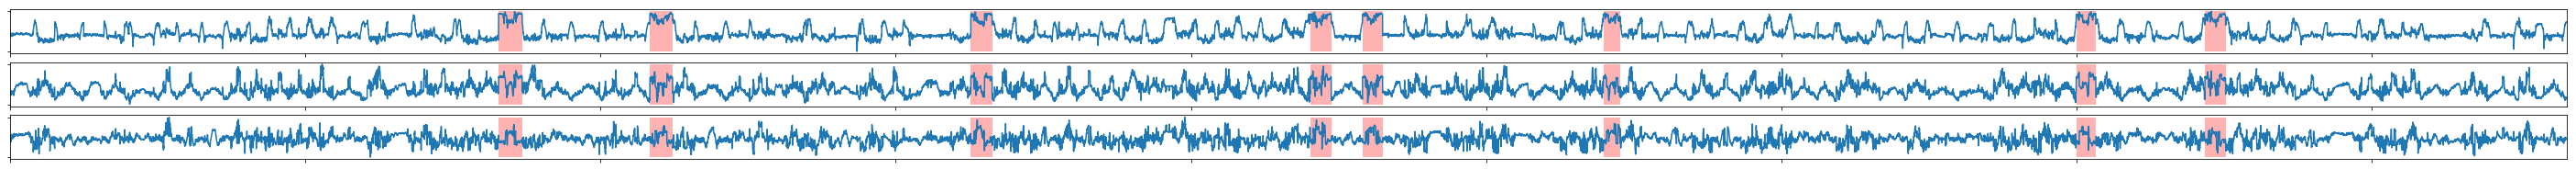

In [51]:
DNAME = 'lunges_vs_squats'
normal = {'pedro': {'lunge': [1]}, 'sergey': {'lunge': [1]}, 'vincent': {'lunge': [1]}}
anomaly = {'vincent': {'squat': [1]}}
ids, labels = filter_id_labels(df_index, normal, anomaly, 8, sort=True, shuffle=True)
df, full_df = apply_filter_and_PCA(df_angles, ids, labels, ndims=3)

plot_angles(df, full_df, full_df.columns, plot_angles=False)

In [52]:
# (w_size, w_increment, bin_size)
wc = [(10, 1, 10)]

for i, c in enumerate(wc):
    settings = {'dname': DNAME, 'scaling': False, 'data_type': 'multivariate', 'discretize': True, 'alphabet_size': 30, 'PCA': 'yes', 'ndims': 3, 'anom_limit': 8,
               'wsize': c[0], 'wincrement': c[1], 'bin_size': c[2]}
    store_frame(df, 'benchmark3_3pca_variation_'+str(i), settings)

## Benchmark 4 (3 PCA): lunge and sidelunge vs squat

This might not be entirely correct, because of the different starting positions of each person. However, for the time being we will just ignore this. If it does not work for this setting, it will certainly not work for the 'perfect' setting.


PCA reduced:


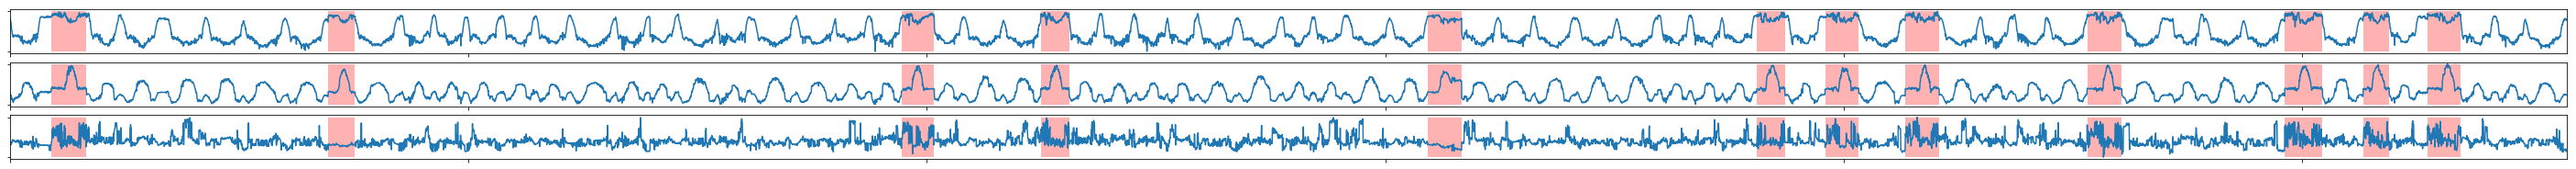

In [60]:
DNAME = 'lunges_and_sidelunges_vs_squats'
normal = {'vincent': {'lunge': [1]}, 'vincent': {'sidelunge': [1]}, 'gust': {'lunge': [1]}, 'gust': {'sidelunge': [1]}}
anomaly = {'gust': {'squat': [1]}}
ids, labels = filter_id_labels(df_index, normal, anomaly, 12, sort=True, shuffle=True)
df, full_df = apply_filter_and_PCA(df_angles, ids, labels, ndims=3)

plot_angles(df, full_df, full_df.columns, plot_angles=False)

In [61]:
# (w_size, w_increment, bin_size)
wc = [(10, 1, 10)]

for i, c in enumerate(wc):
    settings = {'dname': DNAME, 'scaling': False, 'data_type': 'multivariate', 'discretize': True, 'alphabet_size': 30, 'PCA': 'yes', 'ndims': 3, 'anom_limit': 12,
               'wsize': c[0], 'wincrement': c[1], 'bin_size': c[2]}
    store_frame(df, 'benchmark4_3pca_variation_'+str(i), settings)